# Tutorial

DFTK is a Julia package for playing with plane-wave
density-functional theory algorithms. In its basic formulation it
solves periodic Kohn-Sham equations.

This document provides an overview of the structure of the code
and how to access basic information about calculations.
Basic familiarity with the concepts of plane-wave density functional theory
is assumed throughout. Feel free to take a look at the
[density-functional theory](https://juliamolsim.github.io/DFTK.jl/dev/#density-functional-theory)
chapter for some introductory lectures and introductory material on the topic.

!!! note "Convergence parameters in the documentation"
    We use rough parameters in order to be able
    to automatically generate this documentation very quickly.
    Therefore results are far from converged.
    Tighter thresholds and larger grids should be used for more realistic results.

For our discussion we will use the classic example of
computing the LDA ground state of the
[silicon crystal](https://www.materialsproject.org/materials/mp-149).
Performing such a calculation roughly proceeds in three steps.

In [1]:
using DFTK
using Plots

# 1. Define lattice and atomic positions
a = 10.26  # Silicon lattice constant in Bohr
lattice = a / 2 * [[0 1 1.];  # Silicon lattice vectors
                   [1 0 1.];  # specified column by column
                   [1 1 0.]]

# Load HGH pseudopotential for Silicon
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))

# Specify type and positions of atoms
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# 2. Select model and basis
model = model_LDA(lattice, atoms)
kgrid = [4, 4, 4]  # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 7           # kinetic energy cutoff in Hartree
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-8);

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -7.905266999930         NaN   1.95e-01    4.1 
  2   -7.910014167730   -4.75e-03   2.98e-02    2.0 
  3   -7.910098818235   -8.47e-05   3.20e-03    1.0 
  4   -7.910108965364   -1.01e-05   6.35e-04    2.0 
  5   -7.910109400237   -4.35e-07   9.23e-05    1.6 
  6   -7.910109413867   -1.36e-08   1.24e-05    1.7 
  7   -7.910109414109   -2.43e-10   2.03e-06    1.9 


That's it! Now you can get various quantities from the result of the SCF.
For instance, the different components of the energy:

In [2]:
scfres.energies

Energy breakdown:
    Kinetic             3.0807712 
    AtomicLocal         -2.1784450
    AtomicNonlocal      1.7341037 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5413895 
    Xc                  -2.3925713

    total               -7.910109414109


Eigenvalues:

In [3]:
hcat(scfres.eigenvalues...)

7×10 Array{Float64,2}:
 -0.170033  -0.13162    -0.0881019  …  -0.0560205  -0.114743   -0.069777
  0.201709   0.0912098   0.0125266      0.0114076   0.0423183   0.017918
  0.249665   0.175087    0.176466       0.133226    0.220466    0.112584
  0.249665   0.231789    0.202704       0.16134     0.220466    0.190778
  0.35146    0.360507    0.340562       0.292133    0.321217    0.32774
  0.370379   0.396308    0.389909   …   0.332169    0.388572    0.460772
  0.370379   0.402093    0.412871       0.566117    0.388572    0.463169

`eigenvalues` is an array (indexed by kpoints) of arrays (indexed by
eigenvalue number). The "splatting" operation `...` calls `hcat`
with all the inner arrays as arguments, which collects them into a
matrix.

The resulting matrix is 7 (number of computed eigenvalues) by 8
(number of kpoints). There are 7 eigenvalues per kpoint because
there are 4 occupied states in the system (4 valence electrons per
silicon atom, two atoms per unit cell, and paired spins), and the
eigensolver gives itself some breathing room by computing some extra
states (see `n_ep_extra` argument to `self_consistent_field`).

We can check the occupations:

In [4]:
hcat(scfres.occupation...)

7×10 Array{Float64,2}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

And density:

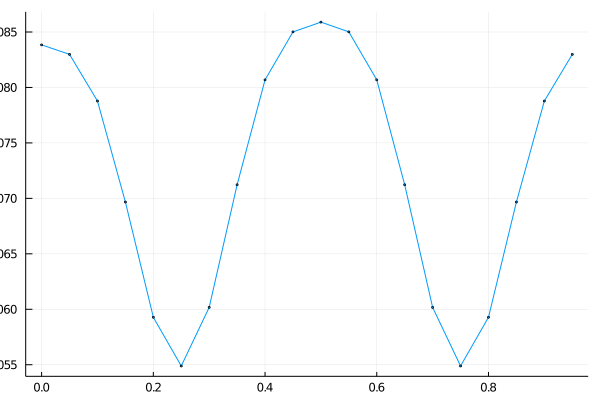

In [5]:
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, scfres.ρ.real[:, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

We can also perform various postprocessing steps:
for instance compute a band structure

Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:00


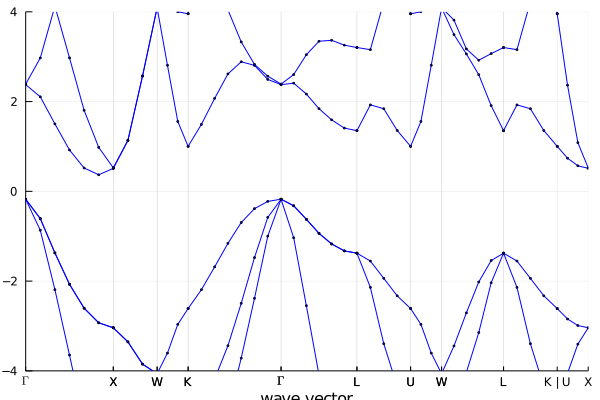

In [6]:
plot_bandstructure(scfres, kline_density=5, unit=:eV)

or forces

In [7]:
forces(scfres)[1]  # Select silicon forces

┌ Warning: Forces for shifted k-Grids not tested
└ @ DFTK /home/travis/build/JuliaMolSim/DFTK.jl/src/terms/terms.jl:66


2-element Array{StaticArrays.SArray{Tuple{3},Float64,1,3},1}:
 [0.004623437541329767, 0.004623361929039953, 0.004623420259486877]
 [-0.004623361929044521, -0.004623437541333845, -0.004623420259486295]

The `[1]` extracts the forces for the first kind of atoms,
i.e. `Si` (silicon) in the setup of the `atoms` list of step 1 above.
As expected, they are almost zero in this highly symmetric configuration.

## Where to go from here
Take a look at the
[example index](https://juliamolsim.github.io/DFTK.jl/dev/#example-index-1)
to continue exploring DFTK.